<a href="https://colab.research.google.com/github/naufalhisyam/TurbidityPrediction-thesis/blob/main/ResNet50_CV_ori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [2]:
!git clone https://github.com/naufalhisyam/TurbidityPrediction-thesis.git
os.chdir('/content/TurbidityPrediction-thesis') 

Cloning into 'TurbidityPrediction-thesis'...
remote: Enumerating objects: 3141, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 3141 (delta 56), reused 117 (delta 31), pack-reused 2990
Receiving objects: 100% (3141/3141), 674.56 MiB | 21.17 MiB/s, done.
Resolving deltas: 100% (185/185), done.
Checking out files: 100% (3487/3487), done.


In [3]:
images = pd.read_csv(r'./Datasets/0degree_lowrange/0degInfo.csv') #load dataset info
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)
Y = train_df[['Turbidity']]

In [4]:
VALIDATION_R2 = []
VALIDATION_LOSS = []
VALIDATION_MSE = []
VALIDATION_MAE = []

name = 'ResNet_0deg_withTL'
tl = True

save_dir = f'saved_models/{name}'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [5]:
def get_model():
    #Create model
    weight = None
    if tl is True:
        weight = 'imagenet'
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=weight, 
                                                input_shape=(224, 224, 3), pooling='avg')
    out = base_model.output
    #x = tf.keras.layers.Dropout(0.9)(out)
    #x =  tf.keras.layers.Dense(4, activation='relu')(out)
    #x =  tf.keras.layers.Dense(2, activation='relu')(x)
    prediction = tf.keras.layers.Dense(1, activation='linear')(out)
    model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    
    return model

def get_model_name(k):
    return 'resnet_'+str(k)+'.h5'

tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator()

kf = KFold(n_splits = 5)
fold_var = 1

In [7]:
for train_index, val_index in kf.split(np.zeros(Y.shape[0]),Y):
  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_images = train_generator.flow_from_dataframe(training_data,
                                                 x_col = "Filepath", y_col = "Turbidity",
                                                 target_size=(224, 224), color_mode='rgb',
                                                 class_mode = "raw", shuffle = True)
  val_images  = train_generator.flow_from_dataframe(validation_data,
                                                  x_col = "Filepath", y_col = "Turbidity",
                                                  target_size=(224, 224), color_mode='rgb',
                                                  class_mode = "raw", shuffle = True)
	
	# CREATE NEW MODEL
  model = get_model()
	# COMPILE NEW MODEL
  opt = tf.keras.optimizers.Nadam(learning_rate=1e-4)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])
	
	# CREATE CALLBACKS
  checkpoint_filepath = f'{save_dir}/{get_model_name(fold_var)}'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                  monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
  history = model.fit(train_images, epochs=200,
                      callbacks=callbacks_list,
                      validation_data=val_images)
	
	# LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(f"{save_dir}/resnet_"+str(fold_var)+".h5")
	
  results = model.evaluate(val_images)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_R2.append(results['R2'])
  VALIDATION_MAE.append(results['mae'])
  VALIDATION_MSE.append(results['mse'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

Found 388 validated image filenames.
Found 98 validated image filenames.
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 31.9360 - mae: 32.4291 - mse: 1875.3861 - R2: -0.3769
Epoch 1: val_loss improved from inf to 232.82013, saving model to saved_models/ResNet_0deg_withTL/resnet_1.h5
13/13 [==============================] - 46s 658ms/step - loss: 31.9360 - mae: 32.4291 - mse: 1875.3861 - R2: -0.3769 - val_loss: 232.8201 - val_mae: 233.3201 - val_mse: 54988.3828 - val_R2: -42.1531
Epoch 2/200
13/13 [==============================] - ETA: 0s - loss: 11.3757 - mae: 11.8620 - mse: 302.9475 - R2: 0.7776
Epoch 2: val_loss improved from 232.82013 to 180.87769, saving model to saved_models/ResNet_0deg_withTL/resnet_1.h5
13/13 [==============================] - 6s 452ms/step - loss: 11.3757 - mae: 11.8620 - mse: 302.9475 - R2: 0.7776 - val_loss: 180.8777 - val_mae: 181.3777 - val_mse: 33123.7812 - val_R2: -24.

In [8]:
val_df = pd.read_csv(r'./Datasets/0degree_val/0degInfo.csv')

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 486 validated image filenames.
Found 55 validated image filenames.
Found 25 validated image filenames.


In [9]:
min_fold = min(range(len(VALIDATION_LOSS)), key=VALIDATION_LOSS.__getitem__) + 1

model = get_model()
model.load_weights(f"{save_dir}/resnet_"+str(min_fold)+".h5")
opt = tf.keras.optimizers.Nadam()
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

In [10]:
pred = np.squeeze(model.predict(val_images))
true = val_images.labels
residuals = true - pred

score = model.evaluate(val_images)
print('sampel air score  ',score)

test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

train_score = model.evaluate(train_images)
test_score = model.evaluate(test_images)
print('test  ',test_score)
print('train  ', train_score)

1/1 [==============================] - 2s 2s/step - loss: 10.2429 - mae: 10.6817 - mse: 240.6168 - R2: 0.2380
sampel air score   [10.242905616760254, 10.681726455688477, 240.6167755126953, 0.23802798986434937]
2/2 [==============================] - 0s 91ms/step - loss: 2.1365 - mae: 2.5963 - mse: 9.6388 - R2: 0.9910
test   [2.1364853382110596, 2.596308469772339, 9.638751983642578, 0.9910481572151184]
train   [1.236011266708374, 1.663588523864746, 4.821241855621338, 0.9964161515235901]


In [11]:
predicted = pd.Series(pred)
truevalue = pd.Series(true)
frame = { 'Predicted': predicted, 'True Val': truevalue }
result = pd.DataFrame(frame)
rslt_df = result.sort_values(by = 'True Val')
rslt_df

,Predicted,True Val
3,0.380346,0.8
16,0.317400,0.8
8,0.369508,0.8
9,0.725713,0.8
14,0.478331,0.8
4,2.898595,9.7
19,3.449304,9.7
18,3.812623,9.7
10,2.607710,9.7
13,2.842860,9.7


In [12]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test
shap_test = shapiro(test_residuals)
shap_train = shapiro(train_residuals)
shap_air = shapiro(residuals)

print('test', shap_test)
print('train', shap_train)
print('air', shap_air)

test (0.9825067520141602, 0.6013597249984741)
train (0.9660959839820862, 3.6865959174292584e-09)
air (0.854407548904419, 0.002137856325134635)


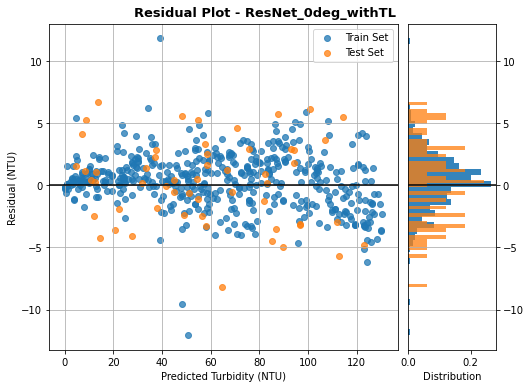

In [13]:
plot_dir = f'plots/{name}'
if not os.path.exists(plot_dir):
  os.makedirs(plot_dir)

f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})

f.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold',  y=0.92) 
axs[0].scatter(train_pred,train_residuals, label='Train Set', alpha=0.75, color='tab:blue')   
axs[0].scatter(test_pred,test_residuals, label='Test Set', alpha=0.75, color='tab:orange')
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=50, orientation="horizontal", density=True, alpha=0.9, color='tab:blue')
axs[1].hist(test_residuals, bins=50, orientation="horizontal", density=True, alpha=0.75, color='tab:orange')
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'{save_dir}/residualPlottraintest_{name}.png', dpi=150)
plt.savefig(f'{plot_dir}/residualPlottraintest_{name}.png', dpi=150)
plt.show()

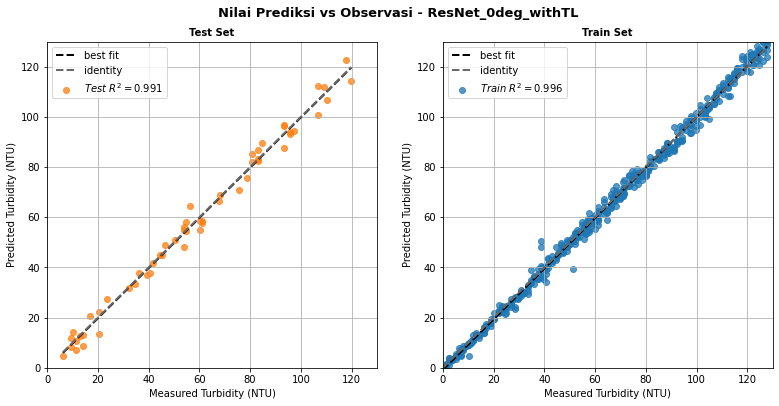

In [14]:
fig, ax = plt.subplots(1,2,figsize=(13,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

ax[0].scatter(test_true,test_pred, label=f'$Test\ R^2=${round(test_score[3],3)}',color='tab:orange', alpha=0.75)
theta = np.polyfit(test_true, test_pred, 1)
y_line = theta[1] + theta[0] * test_true
ax[0].plot([test_true.min(), test_true.max()], [y_line.min(), y_line.max()],'k--', lw=2,label='best fit')
ax[0].plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[0].set_xlabel('Measured Turbidity (NTU)')
ax[0].set_ylabel('Predicted Turbidity (NTU)')
ax[0].set_title(f'Test Set', fontsize=10, fontweight='bold')
ax[0].set_xlim([0, 130])
ax[0].set_ylim([0, 130])
ax[0].grid()
ax[0].legend()

ax[1].scatter(train_true,train_pred, label=f'$Train\ R^2=${round(train_score[3],3)}', color='tab:blue', alpha=0.75)
theta2 = np.polyfit(train_true, train_pred, 1)
y_line2 = theta2[1] + theta2[0] * train_true
ax[1].plot([train_true.min(), train_true.max()], [y_line2.min(), y_line2.max()],'k--', lw=2,label='best fit')
ax[1].plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[1].set_xlabel('Measured Turbidity (NTU)')
ax[1].set_ylabel('Predicted Turbidity (NTU)')
ax[1].set_title(f'Train Set', fontsize=10, fontweight='bold')
ax[1].set_xlim([0, 130])
ax[1].set_ylim([0, 130])
ax[1].grid()
ax[1].legend()

plt.savefig(f'{save_dir}/predErrorPlottraintest_{name}.png', dpi=150)
plt.savefig(f'{plot_dir}/predErrorPlottraintest_{name}.png', dpi=150)
plt.show()

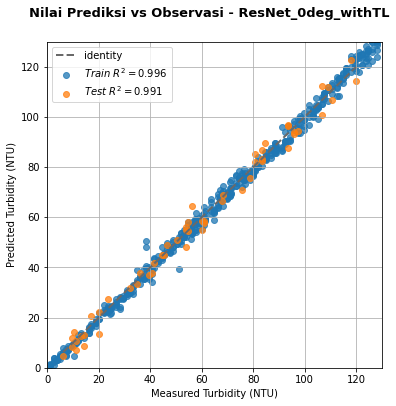

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)


ax.scatter(train_true,train_pred, label=f'$Train\ R^2=${round(train_score[3],3)}', color='tab:blue', alpha=0.75)
ax.scatter(test_true,test_pred, label=f'$Test\ R^2=${round(test_score[3],3)}',color='tab:orange', alpha=0.75)
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax.set_xlabel('Measured Turbidity (NTU)')
ax.set_ylabel('Predicted Turbidity (NTU)')
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()


plt.savefig(f'{save_dir}/predErrorPlottraintestgabung_{name}.png', dpi=150)
plt.savefig(f'{plot_dir}/predErrorPlottraintestgabung_{name}.png', dpi=150)
plt.show()

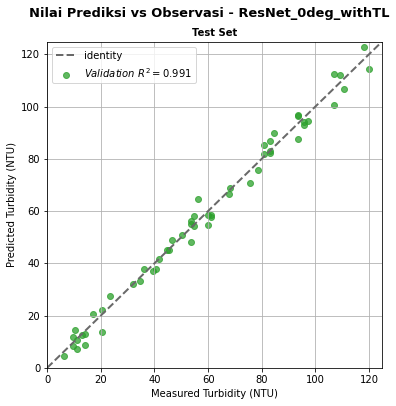

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

amax = test_pred.max()
delt = abs(test_true.max() - amax) + 2

ax.scatter(test_true,test_pred, label=f'$Validation\ R^2=${round(test_score[3],3)}',color='tab:green', alpha=0.75)
theta = np.polyfit(test_true, test_pred, 1)
y_line = theta[1] + theta[0] * test_true
#ax.plot([test_true.min(), test_true.max()+delt], [y_line.min(), y_line.max()+delt],'k--', lw=2,label='best fit')
ax.plot([0,amax+2], [0,amax+2], 'k--', lw=2, label='identity',color='dimgray')
ax.set_xlabel('Measured Turbidity (NTU)')
ax.set_ylabel('Predicted Turbidity (NTU)')
ax.set_title(f'Test Set', fontsize=10, fontweight='bold')
ax.set_xlim([0,amax+2])
ax.set_ylim([0,amax+2])
ax.grid()
ax.legend()

plt.savefig(f'{save_dir}/predErrorPlotVal_{name}.png', dpi=150)
plt.savefig(f'{plot_dir}/predErrorPlotVal_{name}.png', dpi=150)
plt.show()

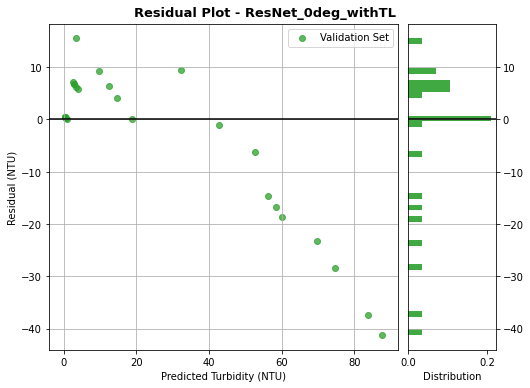

In [17]:
if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})

f.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold',  y=0.92) 
axs[0].scatter(pred,residuals, label='Validation Set', alpha=0.75, color='tab:green')   
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(residuals, bins=50, orientation="horizontal", density=True, alpha=0.9, color='tab:green')
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'{save_dir}/residualPlotVal_{name}.png', dpi=150)
plt.savefig(f'{plot_dir}/residualPlotVal_{name}.png', dpi=150)
plt.show()

In [18]:
cv_df = pd.DataFrame.from_dict({'val_loss': VALIDATION_LOSS, 'val_mae': VALIDATION_MAE, 'val_mse': VALIDATION_MSE, 'val_R2': VALIDATION_R2}, orient='index').T
cv_csv_file = f'{save_dir}/cross_val.csv'
with open(cv_csv_file, mode='w') as f:
    cv_df.to_csv(f)
    
rslt_csv_file = f'{save_dir}/val_result.csv'
with open(rslt_csv_file, mode='w') as f:
    rslt_df.to_csv(f)

rslt_csv_file = f'{plot_dir}/val_result.csv'
with open(rslt_csv_file, mode='w') as f:
    rslt_df.to_csv(f)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/modelperbaikan/ResNet/{name}"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_models/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

save_path2 = f"/content/gdrive/MyDrive/MODEL BERHASIL/PlotPerbaikan/ResNet/{name}"
if not os.path.exists(save_path2):
  os.makedirs(save_path2)

oripath2 = "plot_dir/."
!cp -a "{oripath2}" "{save_path2}" # copies files to google drive